# Environment setup

A [Mesa](https://mesa.readthedocs.io/en/master/index.html) framework in Python is utilized to simulate the agent-based model. 

In [ ]:
pip install mesa==0.8.6

# The model

The study examines various parameters to observe when the cooperative behaviors appear by agent-based simulation. In the code below, the positions of initial members in different generated social networks are observed for its relationship with the number of agents cooperating at the end of the simulation.

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 26 16:41

Tue May 5, 10:39 2020
v0.15: Update price function, minimum threshold to become a member, portion of 
       attitude or subjective norm.

Tue Apr 28 10:14 2020
v0.14: Change the flow of attitude and subjective norm to follow the extensive
       game that models the situation better.

Sun Jan 12 16:50 2019
v0.13: Clean up codes after introducing TPB into the model.

Wed Dec 25 21:25 2019
v0.12: Set baseline for new improvement.

Tue Nov 26 18:39 2019
v0.11: Added parameters for consensus and conflict payoff. 

Sun Nov 24 11:53 2019
v0.10: Added aspiration-based learning and changed the logic that all members
       consider to exit if a conflict occurs. 

Tue Nov 12 19:30 2019
v0.9: Added a function to exit the group after experiencing conflicts. 

Tue Nov 12 14:13 2019
v0.8: Added a function to calculate new learning level after experiencing
      conflicts. 

Sun Nov 10 18:11 2019
v0.7: Updated the comments. 

Sat Nov 9 22:07 2019
v0.6: Changed substantially to include conflict process and group task status.      

v0.5: Updated maximum working hours per agent based on learning rate of all 
      agents in a task.

@author: Albert Yosua
"""

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import random
import networkx as nx
import math
import pandas as pd

class FarmerAgent(Agent):
    """ An agent."""
    def __init__(self, 
                 unique_id, 
                 model,
                 learning_rate
                 ):
        super().__init__(unique_id, model)
        self.learning_rate = learning_rate
        self.aspiration = 0 # Real value
        self.total_payoff = 0
        self.current_payoff = 0
        self.attitude = 0
        self.subjective_norm = 0
        self.behavioral_control = round(random.uniform(0.1, 0.9), 1)
        self.intention = 0
        self.aspiration_rescaling = 0
        self.stimulus = 0
        self.exit = 0
        self.member = 0
        self.survive = 0
    
    def step(self):
        # Aspiration will be updated as long as the agent has not exited
        # or not yet a member
        if self.exit == 0:
            update_aspiration_static_ex(self)
        else:
            self.stimulus = 0
            self.current_payoff = 0
        
        self.total_payoff += self.current_payoff

def update_aspiration_static_ex(self):
    # Previous step's value
    # Amount of money that an agents aspires to get in joining co-op
    asp = self.aspiration
    profit = 0
    
    if self.member == 1:      
        # During joining the co-op, an agent checks profit they receive
        # Update aspiration value based on received profit
        if self.model.farmer_profit_amount > 0:           
            profit = self.model.farmer_profit_amount
            
            # Update aspiration
            dynamic = self.model.is_aspiration_dynamic           
            if dynamic:
                 # Habituation concept
                 h = self.model.learning_rate_asp                 
                 self.aspiration = (1 - h) * asp + h * profit
        
        # Real value
        self.stimulus = profit - asp
        
        # Update the attitude level.    
        stimulus = self.stimulus
        
        if stimulus != 0 and asp != 0:
            s = stimulus / self.model.max_payoff
        else:
            s = 0
        
        l_r = self.learning_rate
        a = self.attitude
    
        if s >= 0:        
            a = a + (1 - a) * l_r * s
        else:        
            a = a + a * l_r * s
    
        self.attitude = a
        
    else:
        # Current decision is still not joining the co-op
        profit = 0

    self.current_payoff = profit
    
    # Update the subjective norm level
    # Get other agents connected to this agent
    connections = list(self.model.network.neighbors(self.unique_id))
    
    # Update the value of cooperativeness level based on other agents' values.
    # Based on Friedkin and Johnsen, 2011
    if len(connections) > 0:
        n = len(connections)
        agents_list = [agent for agent in self.model.schedule.agents
                       if agent.unique_id in connections]
        
        sum_cooperativeness = 0

        for agent in agents_list:
            peer_cooperativeness = 0            
            if agent.member == 1:
                peer_cooperativeness = 1                
            sum_cooperativeness += (1 / n) \
                * (peer_cooperativeness - self.subjective_norm) 
            
        self.subjective_norm += self.model.learning_rate_sn \
                                * sum_cooperativeness
        
    # Make sure the upper and lower range is between 0 and 1.
    if self.subjective_norm > 1:
        self.subjective_norm = 1
    elif self.subjective_norm < 0:
        self.subjective_norm = 0

def update_aspiration(self):   
    
    attitude_portion = self.model.attitude_portion
    # Range: [0,1]
    self.aspiration_rescaling = (1 - attitude_portion) * self.subjective_norm \
                                + attitude_portion * self.attitude
    
def update_intention(self):
    self.intention = self.aspiration_rescaling

def update_membership(self):
            
    # If not a member
    if self.member == 0:
        # Enter co-op if currently not a member
        if self.intention >= self.model.enter_threshold:
            self.member = 1
    # If a member or previously a member
    else:
        # If not yet exit
        if self.exit == 0:
            # Exit co-op if currently a member
            if self.intention < self.model.exit_threshold:
                self.exit = 1
   
def get_total_cooperative_agents(model):
    cooperative_agents = sum(1 for agent 
                         in model.schedule.agents 
                         if agent.exit == 0 and agent.member == 1)
    
    return cooperative_agents

def get_farmer_profit_amount(model):
    return model.farmer_profit_amount

def get_total_defective_agents(model):
    cooperative_agents = sum(1 for agent 
                         in model.schedule.agents 
                         if not (agent.exit == 0 and agent.member == 1))
    
    return cooperative_agents
            
class FarmerModel(Model):
    """A model with some number of agents."""
    def __init__(self, 
                 N, 
                 learning_rate,
                 learning_rate_sn,
                 nearest_neighbors_number,
                 joined_agents,
                 is_aspiration_dynamic,
                 is_initial_members_pos_random,
                 attitude_portion,
                 enter_threshold,
                 exit_threshold,
                 survive_threshold,
                 learning_rate_asp,
                 profit_noise_max,
                 profit_noise_min,
                 network_type,
                 seed=None
                 ):
        
        self.num_agents = N
        self.learning_rate_sn = learning_rate_sn
        self.nearest_neighbors_number = nearest_neighbors_number
        self.is_aspiration_dynamic = is_aspiration_dynamic       
        self.is_initial_members_pos_random = is_initial_members_pos_random
        self.attitude_portion = attitude_portion
        self.enter_threshold = enter_threshold
        self.exit_threshold = exit_threshold
        self.survive_threshold = survive_threshold
        self.learning_rate_asp = learning_rate_asp
        self.profit_noise_max = profit_noise_max
        self.profit_noise_min = profit_noise_min
        self.network_type = network_type
        
        self.schedule = RandomActivation(self)
        # For batch set up
        self.running = True
        
        if self.network_type == 0:
            # Create a network
            # n - the number of nodes
            # k - each node is joined with its k nearest neighbours
            # p - the probability of rewiring each edge
            self.network = nx.watts_strogatz_graph(n=self.num_agents, 
                                                   k=self.nearest_neighbors_number, 
                                                   p=0.1, 
                                                   seed=seed)
        elif self.network_type == 1:
            self.network = nx.extended_barabasi_albert_graph(n=self.num_agents, 
                                                             m=self.nearest_neighbors_number, 
                                                             p=0.1, 
                                                             q=0.1, 
                                                             seed=seed)

        # Create agents based on node ID from the network
        for i in self.network:
            a = FarmerAgent(i, self, 
                            learning_rate,
                            )            
            self.schedule.add(a)      
            
        # Update initial joined status
        joined_agents_num = round(joined_agents*N)
        
        pos_random = self.is_initial_members_pos_random
        if pos_random:
            # Select randomly
            joined_agents_list = random.sample(range(joined_agents_num), 
                                               joined_agents_num)
        
        else:
            # Select from top number of degrees
            sorted_degrees = sorted([(d, n) for n, d in self.network.degree()], 
                                     reverse=True)
            joined_agents_list = [n for d, n in 
                                  sorted_degrees[:joined_agents_num]]
        
        # All calls to random will output the same results 
#        random.seed(1)
        
        initial_members_threshold_bottom = self.enter_threshold
        initial_members_threshold_top = 0.99
        initial_non_members_threshold_bottom = 0.00
        initial_non_members_threshold_top = self.enter_threshold - 0.01
        
        self.joined_agents_list = joined_agents_list
        for a in self.schedule.agents:            
            # Initial members of a co-op
            if a.unique_id in joined_agents_list:
                a.attitude = \
                    round(self.random.
                          uniform(initial_members_threshold_bottom,
                                  initial_members_threshold_top), 2)
                a.subjective_norm = \
                    round(self.random.
                          uniform(initial_members_threshold_bottom,
                                  initial_members_threshold_top), 2)
            # Outsider
            else:
                a.attitude = \
                    round(self.random.
                          uniform(initial_non_members_threshold_bottom,
                                  initial_non_members_threshold_top), 2)
                a.subjective_norm = \
                    round(self.random.
                          uniform(initial_non_members_threshold_bottom,
                                  initial_non_members_threshold_top), 2)
            update_aspiration(a)  
            update_intention(a)
            
        # Outsider -> Consider -> Member
        
        # Count how many agents joined the co-op (at initialisation only)
        self.join = 0;
        self.join = sum(1 for agent 
                        in self.schedule.agents 
                        if agent.intention > self.enter_threshold)
        
        for a in self.schedule.agents:
            if a.intention > 0.50:
                a.member = 1
            # Take some outsiders to become members
            else:
                if a.intention > self.enter_threshold:
                    a.member = 1

        self.coop_profit_ratio = 0.2
        self.farmer_profit_ratio = 0.8 
        
        # Proportional profit
#        portion = self.join / self.num_agents
#        self.profit_amount = portion**2 * 1000
#        self.max_payoff = self.farmer_profit_ratio / self.num_agents * 1000

        # Linear profit
#        self.profit_amount = 10 * self.join
#        self.max_payoff = 10 * self.num_agents
        
        # Logistic 
        self.var_b = 0.8
        portion = self.join / self.num_agents
        sigmoid_val = 1 / (1 + math.exp(-10 * (portion - self.var_b)))        
        self.profit_amount = sigmoid_val * 1000
        
        # max_payoff can be calculated by given function
        a = pd.Series(list(range(1, self.num_agents+1)))
        a = a.divide(50)
        b = a.apply(lambda x: (1 / (1 + math.exp(-10 * (x - self.var_b)))) \
                    * 1000 *  self.farmer_profit_ratio / (x * self.num_agents))
        self.max_payoff = b.max()
        
        if self.join == 0:
            self.farmer_profit_amount = 0
        else:
            self.farmer_profit_amount = self.farmer_profit_ratio / self.join \
                                        * self.profit_amount        
                                                 
        # Initial aspiration equals to the received profit
        for a in self.schedule.agents:            
            # Initial aspiration value
            
            # Low - 1 person
#            a.aspiration = self.max_payoff / self.num_agents
            
            # High - 10 persons
#            a.aspiration = self.farmer_profit_ratio / self.num_agents \
#                           * (1 / (1 + math.exp(-10 * (0.1 - self.var_b)))) \
#                           * 1000
            # Based on 10 persons
#            a.aspiration = b.iloc[9]
            
            # Based on percentage from the max payoff
            a.aspiration = 0.1 * self.max_payoff 
            
        self.datacollector = DataCollector(
        # A function to call
        model_reporters={"cooperative_agents": get_total_cooperative_agents,
                         "defective_agents": get_total_defective_agents,
                         "farmer_profit": get_farmer_profit_amount
                         },  
        # An agent attribute
        agent_reporters={"current_payoff": "current_payoff",
                         "aspiration": "aspiration",
                         "total_payoff": "total_payoff",
                         "stimulus": "stimulus",
                         "attitude": "attitude",
                         "member": "member",
                         "exit": "exit",
                         "subjective_norm": "subjective_norm",
                         "intention": "intention",  
                         "survive": "survive",
                         "behavioral_control": "behavioral_control",
                         "aspiration_rescaling": "aspiration_rescaling",
                         })  
    def step(self):
        self.datacollector.collect(self)
        '''Advance the model by one step.'''
        self.schedule.step()
        
        # Update cooperativeness of all agents simultaneously
        for agent in self.schedule.agents:
            if agent.exit == 0:
                update_aspiration(agent)
                update_intention(agent)
                update_membership(agent)
        
        # Count how many agents joined the co-op
        self.join = sum(1 for agent 
                        in self.schedule.agents 
                        if agent.exit == 0 and
                        agent.member == 1)
               
        # Update new profit for next step according to specific criteria
#        self.profit_amount = round(random.uniform(900, 1000), 1)
        
        # Use sigmoid function
#        members_portion = self.join / self.num_agents
#        sigmoid_val = 1/(1+math.exp(-20*(members_portion-0.1)))
#        self.profit_amount = 100 * sigmoid_val
        
        # y = 10x
        # The profit is linear with increasing number of members
#        self.profit_amount = 10 * self.join
        
        # Proportional profit
#        portion = self.join / self.num_agents
#        self.profit_amount = portion**2 * 1000
        
        # Linear profit
#        self.profit_amount = 10 * self.join
        
        # Logistic profit
        portion = self.join / self.num_agents
        sigmoid_val = 1 / (1 + math.exp(-10 * (portion - self.var_b)))
        self.profit_amount = sigmoid_val * 1000
        
        if self.join == 0:
            self.farmer_profit_amount = 0
        else:
            self.farmer_profit_amount = self.farmer_profit_ratio / self.join \
                                        * self.profit_amount
            
            # Set the range of noise to profit
            noise = self.random.randint(self.profit_noise_min, 
                                   self.profit_noise_max)
#            print(noise)
#            noise = random.randint(0, 0)
            if (noise + self.farmer_profit_amount) < self.max_payoff and \
                (noise + self.farmer_profit_amount) > 0:
                self.farmer_profit_amount += noise



---


The model is simulated based on particular parameter settings.

-----
Initial members: 20
Nearest neighbor: 5
Results members: 50


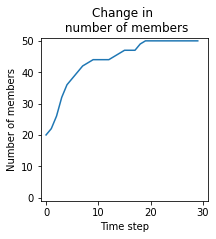

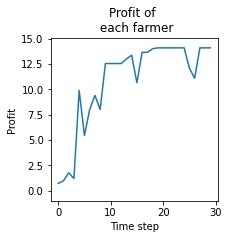

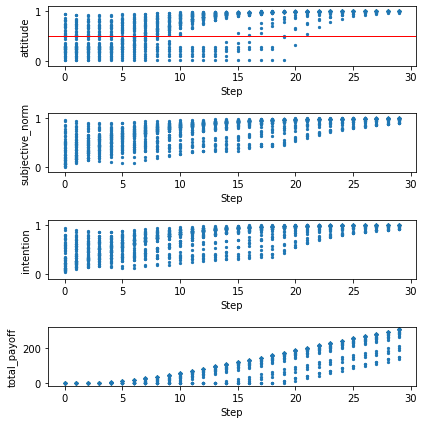

<Figure size 432x288 with 0 Axes>

In [12]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 26 17:12:40 2019

@author: Albert Yosua
"""

# from model import FarmerModel

import matplotlib.pyplot as plt
all_resources = []

all_coordination_costs = []
all_total_tasks_completed = []
all_total_conflicts = []
all_completed_times = []
all_total_rejections = []
all_total_team_joined = []
all_total_consensus = []
all_total_cooperativeness = []
agents = []

number_of_agents = 50
number_of_iterations = 1
number_of_steps = 30

# range_iter = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# range_iter = [0.1, 0.2, 0.3, 0.4, 0.5]
# range_iter = [3, 5, 7]
range_iter = [5]

for j in range_iter:
    count_task_2 = 0
    count_task_3 = 0
    count_task = 0
    task_2_completion_time = []
    task_3_completion_time = []
    task_completion_time = []

    # Run the model
    model = FarmerModel(number_of_agents, 
                        learning_rate=0.35, # alpha
                        learning_rate_sn=0.15, # epsilon
                        nearest_neighbors_number=2,
                        joined_agents=0.4,
                        is_aspiration_dynamic=0, # Static: 0, Dynamic: 1
                        is_initial_members_pos_random=0, # High conn.: 0, Random: 1
                        attitude_portion=0.2,
                        enter_threshold=0.4,
                        exit_threshold=0.3,
                        survive_threshold=0,
                        learning_rate_asp=0.9, # delta
                        profit_noise_max=5,
                        profit_noise_min=-5,
                        network_type=1, # WS = 0, BA = 1          
#                        seed=1
                        )
    
    # How to divide the initial population to join and out?
    
    print("-----")
    print("Initial members:", model.join)
    print("Nearest neighbor:", j)
    
    for i in range(number_of_steps):
        model.step()
#        print("Step:", i, "Join:", model.join)
        
#        print("----- Step", i)
#        a = next(agent for agent in model.schedule.agents)
#        print("Agent 0")
#        print("{:.2f}".format(model.farmer_profit_amount), 
#              "{:.2f}".format(a.aspiration), 
#              "{:.2f}".format(a.subjective_norm)) 
#        print("{:.2f}".format(model.farmer_profit_amount),
#              "{:.2f}".format(model.profit_amount))

    
#    cooperative_agents = sum(1 for agent 
#                             in model.schedule.agents 
#                             if agent.cooperativeness > 0.50)
#    defective_agents = sum(1 for agent 
#                             in model.schedule.agents 
#                             if agent.cooperativeness <= 0.50)
#    print(cooperative_agents, defective_agents)
    print("Results members:", model.join)
#    print("Farmer profit:", 
#          "{:.2f}".format(model.farmer_profit_amount))
    
    agents = model.datacollector.get_agent_vars_dataframe()
    
    model_data = model.datacollector.get_model_vars_dataframe()    
    model_data.cooperative_agents.plot(ylim=(-1,number_of_agents+1),
                                       xlim=(-1, number_of_steps+1),
                                       figsize=(3,3),
                                       title="Change in \n number of members")
    plt.xlabel('Time step')
    plt.ylabel('Number of members')
    plt.figure()
    model_data.farmer_profit.plot(ylim=(-1,model.max_payoff+1),
                                  figsize=(3,3),
                                  title="Profit of \n each farmer")
    plt.xlabel('Time step')
    plt.ylabel('Profit')
    
    fig, (ax_1, ax_2, ax_3, ax_4) = plt.subplots(4,1,figsize=(6,6))
    
    for i in model.schedule.agents:
        an_agent = agents.xs(i.unique_id, level="AgentID")
        an_agent.reset_index().plot(kind='scatter', 
                            x='Step', 
#                            y='total_payoff',
#                            ylim=(-0.1, 50.1),
                            y='attitude',
                            ylim=(-0.1, 1.1), 
#                            ylim=(0.3, 0.7),
#                            y='aspiration',
#                            ylim=(-0.1, 4.1),
                            ax=ax_1, 
                            marker='.')
        ax_1.axhline(y=0.5,linewidth=0.5,color='red')
        
        an_agent.reset_index().plot(kind='scatter', 
                            x='Step', 
#                            y='attitude',
                            y='subjective_norm',
#                            y='aspiration',
#                            y='behavioral_control',
#                            y='aspiration_rescaling',
#                            y='total_payoff',
#                            ylim=(-0.1, 50.1),
#                            y='cooperativeness',
                            ylim=(-0.1, 1.1), 
#                            y='aspiration',
#                            ylim=(-0.1, 16.1),
                            ax=ax_2, 
                            marker='.')  
        
        an_agent.reset_index().plot(kind='scatter', 
                            x='Step', 
#                            y='total_payoff',
#                            ylim=(-0.1, 50.1),
                            y='intention',
                            ylim=(-0.1, 1.1), 
#                            ylim=(0.3, 0.7),
#                            y='aspiration',
#                            ylim=(-0.1, 4.1),
                            ax=ax_3, 
                            marker='.')
        
        an_agent.reset_index().plot(kind='scatter', 
                            x='Step', 
#                            y='total_payoff',
#                            ylim=(-0.1, 50.1),
                            y='total_payoff',
#                            ylim=(-0.1, 1.1), 
#                            ylim=(0.3, 0.7),
#                            y='aspiration',
#                            ylim=(-0.1, 4.1),
                            ax=ax_4, 
                            marker='.')
    
    fig.tight_layout()
    plt.figure(range_iter.index(j))
    plt.show()
  

# Batch run

The model with various parameter settings is repeated 100 times. One simulation has 30 steps. The observed value from the simulation is averaged and displayed in the results. 

The results might not be very clear and easy to understand at this stage. Next step is to visualize the results in different format.

20it [00:00, 41.17it/s]


Text(0.5, 0, 'nearest_neighbors_number')

<Figure size 288x288 with 0 Axes>

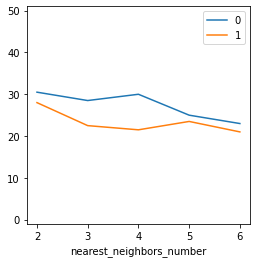

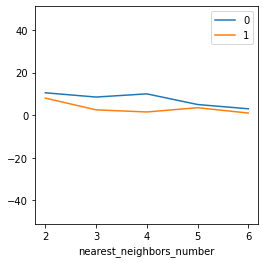

In [15]:
# run_batch_r_sn_n.py

from mesa.batchrunner import BatchRunner

# from model import FarmerModel

import numpy as np

num_iterations = 2
number_of_steps = 30

fixed_params = {"N": 50,  # Number of agents
                "learning_rate": 0.35,
                "learning_rate_sn": 0.15,
#                "nearest_neighbors_number": 5,
                "joined_agents": 0.4,
                "is_aspiration_dynamic": 0, # Static: 0, Dynamic: 1
#                "is_initial_members_pos_random": 0, # High conn.: 0, Random: 1
                "attitude_portion": 0.2,
                "enter_threshold": 0.4,
                "exit_threshold": 0.5,
                "survive_threshold": 0,
                "learning_rate_asp": 0.9,
                "profit_noise_max": 5,
                "profit_noise_min": -5,
                "network_type": 1, # WS = 0, BA = 1
                }

range_1 = [2, 3, 4, 5, 6] # BA, nearest_neighbors_number - barabasi albert [1]

# range_1 = [4, 6, 8, 10, 12] # WS, nearest_neighbors_number - watts strogatz [0]

range_2 = [0, 1] # is_initial_members_pos_random
 
# Note: changing the value of parameter should be applied to plot section below
variable_params = {"nearest_neighbors_number": range_1,
                   "is_initial_members_pos_random": range_2
                   }

batch_run = BatchRunner(FarmerModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=num_iterations,
                        max_steps=number_of_steps,
                        model_reporters={
#                            "Mean": compute_mean,
#                            "Stdev": compute_stdev,
                            "datacollector": lambda m: m.datacollector,
#                            "completed_time": lambda m: m.completed_time
                            },
#                        agent_reporters={
#                              "State": lambda a: a.current_state, 
#                              "Reward": lambda a: a.reward, 
#                             }
                        )
batch_run.run_all()

run_data = batch_run.get_model_vars_dataframe()

#run_data_agent = batch_run.get_agent_vars_dataframe()

import pandas as pd
import seaborn as sns
import statistics 
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))

df_collection = pd.DataFrame(data=None, index=range_2, columns=range_1)
df_initial_collection = pd.DataFrame(data=None, index=range_2, columns=range_1)

for j in range_1:
    
    for k in range_2:
    
        df_temp_0 = run_data.query('nearest_neighbors_number==' + str(j) + ' and '
                               + 'is_initial_members_pos_random==' + str(k))
    
#    df_temp_0 = run_data.query('learning_rate==' + str(j))
    
        count = 0
        initial_members = []
        cooperative_agents = []

        for i in df_temp_0.iterrows():
            # Get each agent data
            df_temp \
                = i[1]['datacollector'].get_model_vars_dataframe().copy()    
                
            # Get all agents in specific status
            df_temp_count = df_temp.query('index == ' + str(number_of_steps - 1))
            
            cooperative_agents.append(df_temp_count.iloc[0]['cooperative_agents'])
            
            diff = df_temp.iloc[-1]['cooperative_agents'] - \
                   df_temp.iloc[0]['cooperative_agents']
            
            initial_members.append(diff)
      
#        print(k, j, cooperative_agents)
        df_collection.loc[k][j] = statistics.mean(cooperative_agents)
        df_initial_collection.loc[k][j] = statistics.mean(initial_members)
        
#        df_collection[str(j)+'_'+str(k)] = cooperative_agents
   
df_collection.T.plot(figsize=(4,4),ylim=(-1,51))
plt.xlabel('nearest_neighbors_number')
df_initial_collection.T.plot(figsize=(4,4),ylim=(-51,51))
plt.xlabel('nearest_neighbors_number')



---


The structure of the network in different settings is observed to examine the effect of network structure and the number of connections owned by the initial members on the observed cooperative behaviors among agents at the end of the simulation. 

The following codes show that the results are saved to CSV format for further data analysis. An overview of how data might look like from CSV file is also presented in the figure below.

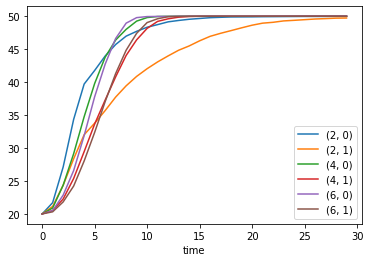

In [18]:
# df_test = pd.concat(df_collection_temp_2)
# df_test.index.names = ['nearest_neighbors_number', 'is_initial_members_pos_random', 'time']

# from google.colab import drive
# drive.mount('/drive')

# df_test.to_csv('/drive/My Drive/Colab Notebooks/CSV/3_ba_en_4_ex_3.csv', header=True)

import pandas as pd
df_test = pd.read_csv('/drive/My Drive/Colab Notebooks/CSV/3_ba_en_4_ex_3.csv', 
                      index_col=[0,1,2],
                      squeeze=True # Return Series instead of DataFrame
                      )

df_test.loc[(2, 0)].plot()
df_test.loc[(2, 1)].plot()
# df_test.loc[(3, 0)].plot()
# df_test.loc[(3, 1)].plot()
df_test.loc[(4, 0)].plot()
df_test.loc[(5, 1)].plot()
# df_test.loc[(5, 0)].plot()
# df_test.loc[(5, 1)].plot()
df_test.loc[(6, 0)].plot()
df_test.loc[(6, 1)].plot()

plt.legend(['(2, 0)', 
            '(2, 1)',
            # '(3, 0)', 
            # '(3, 1)',
            '(4, 0)', 
            '(4, 1)',
            # '(5, 0)', 
            # '(5, 1)',
            '(6, 0)', 
            '(6, 1)',])

# Results

The emergence of cooperative behavior among agents is measured in different structures of network. The comparison between the Watts-Strogatz and Barabási-Albert network also focuses on whether the highly connected initial members have an impact on more farmers becoming members of the co-op.

In the below figure, the focus of analysis is on the change of proportion of farmers over time step. 

In the next figure, the focus of analysis is on the results in a particular time step (last step) in different network configurations.

Text(0.75, 0.03, '(d)')

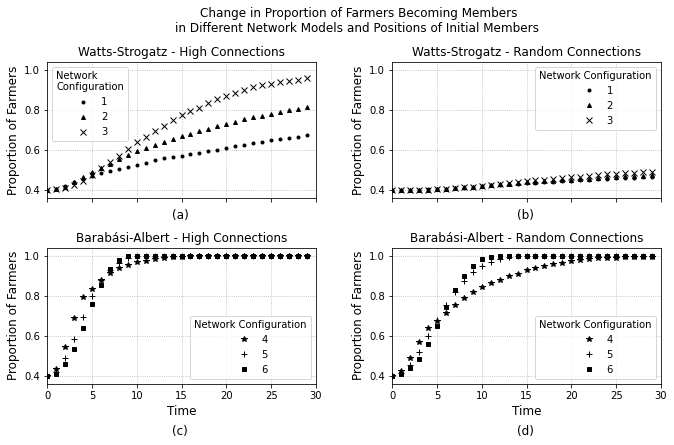

In [19]:
# Combination of WS and BA
# Show each time step data

import pandas as pd

df_test_ws = pd.read_csv('/drive/My Drive/Colab Notebooks/CSV/3_ws_en_4_ex_3.csv', 
                         index_col=[0,1,2],
                         squeeze=True)
df_test_ba = pd.read_csv('/drive/My Drive/Colab Notebooks/CSV/3_ba_en_4_ex_3.csv', 
                         index_col=[0,1,2],
                         squeeze=True)

df_test_ws = df_test_ws.div(50)
df_test_ba = df_test_ba.div(50)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, 
                         figsize=(10,6))
ax0, ax1, ax2, ax3 = axes.flatten()

df_test_ws.loc[(4, 0)].plot(ax=ax0, style=['.k'])
df_test_ws.loc[(4, 1)].plot(ax=ax1, style=['.k'])
df_test_ws.loc[(8, 0)].plot(ax=ax0, style=['^k'], markersize=4)
df_test_ws.loc[(8, 1)].plot(ax=ax1, style=['^k'], markersize=4)
df_test_ws.loc[(12, 0)].plot(ax=ax0, style=['xk'])
df_test_ws.loc[(12, 1)].plot(ax=ax1, style=['xk'])

ax0.set_ylabel('Proportion of Farmers', fontsize='large')
ax0.set_title('Watts-Strogatz - High Connections', fontsize='large')
ax1.set_ylabel('Proportion of Farmers', fontsize='large')
ax1.set_title('Watts-Strogatz - Random Connections', fontsize='large')

ax0.legend(title='Network\nConfiguration', labels=['1', '2', '3'])
ax1.legend(title='Network Configuration', labels=['1', '2', '3'])

df_test_ba.loc[(2, 0)].plot(ax=ax2, style=['*k'])
df_test_ba.loc[(2, 1)].plot(ax=ax3, style=['*k'])
df_test_ba.loc[(4, 0)].plot(ax=ax2, style=['+k'])
df_test_ba.loc[(4, 1)].plot(ax=ax3, style=['+k'])
df_test_ba.loc[(6, 0)].plot(ax=ax2, style=['sk'], markersize=4)
df_test_ba.loc[(6, 1)].plot(ax=ax3, style=['sk'], markersize=4)

ax2.set_ylabel('Proportion of Farmers', fontsize='large')
ax2.set_title(r'Barabási-Albert - High Connections', fontsize='large')
ax3.set_ylabel('Proportion of Farmers', fontsize='large')
ax3.set_title(r'Barabási-Albert - Random Connections', fontsize='large')
ax2.set_xlabel('Time', fontsize='large')
ax3.set_xlabel('Time', fontsize='large')

ax2.legend(title='Network Configuration', labels=['4', '5', '6'])
ax3.legend(title='Network Configuration', labels=['4', '5', '6'])

for ax in axes.reshape(-1): 
  ax.set_xlim(0,30)
  ax.set_ylim(0.36,1.04)
  ax.grid(linestyle=':')

fig.tight_layout(pad=3.0)
fig.suptitle('Change in Proportion of Farmers Becoming Members'
             '\n'
             r'in Different Network Models and Positions of Initial Members ',
             x=0.53, y=1.02, fontsize='large')
plt.text(0.27, 0.53, '(a)', fontsize='large', transform=plt.gcf().transFigure)
plt.text(0.75, 0.53, '(b)', fontsize='large', transform=plt.gcf().transFigure)
plt.text(0.27, 0.03, '(c)', fontsize='large', transform=plt.gcf().transFigure)
plt.text(0.75, 0.03, '(d)', fontsize='large', transform=plt.gcf().transFigure)
# plt.text(0.14, 0.53, '(a) Higher Number of Connections', fontsize='large', transform=plt.gcf().transFigure)
# plt.text(0.75, 0.53, '(b) Random Connections', fontsize='large', transform=plt.gcf().transFigure)
# plt.text(0.14, 0.03, '(c) Higher Number of Connections', fontsize='large', transform=plt.gcf().transFigure)
# plt.text(0.66, 0.03, '(d) Random Connections', fontsize='large', transform=plt.gcf().transFigure)

# plt.savefig('/drive/My Drive/Colab Notebooks/PDF/3_ws_ba_en_4_ex_3.pdf', 
#             format='pdf', dpi=600, bbox_inches = 'tight')



---


From the bar chart below, the higher the connections, the higher the number of members noticed from the results. However, there was no significant change in the number of members in the case of randomly set connections. 

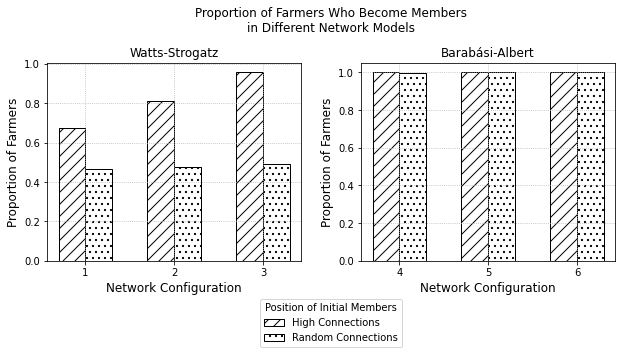

In [20]:
# Combination of WS and BA
# Show summary

import pandas as pd
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, 
                         figsize=(9,4))
ax0, ax1 = axes.flatten()

ws_values_0 = [df_test_ws.loc[(4, 0, 29)],
               df_test_ws.loc[(8, 0, 29)],
               df_test_ws.loc[(12, 0, 29)]]
ws_values_1 = [df_test_ws.loc[(4, 1, 29)],
               df_test_ws.loc[(8, 1, 29)],
               df_test_ws.loc[(12, 1, 29)]]   

ba_values_0 = [df_test_ba.loc[(2, 0, 29)],
               df_test_ba.loc[(4, 0, 29)],
               df_test_ba.loc[(6, 0, 29)]]
ba_values_1 = [df_test_ba.loc[(2, 1, 29)],
               df_test_ba.loc[(4, 1, 29)],
               df_test_ba.loc[(6, 1, 29)]]        

indexes = np.arange(3)
width = 0.3

ax0.bar(x=indexes, width=width, height=ws_values_0, 
        hatch='//', color='white', edgecolor='black')
ax0.bar(x=indexes+width, width=width, height=ws_values_1, 
        hatch='..', color='white', edgecolor='black')
ax0.grid(linestyle=':')

ax0.set_xticks(indexes + width / 2)
ax0.set_xticklabels(['1', '2', '3'])
ax0.set_xlabel('Network Configuration', fontsize='large')
ax0.set_ylabel('Proportion of Farmers', fontsize='large')
ax0.set_title('Watts-Strogatz', fontsize='large')

ax1.bar(x=indexes, width=width, height=ba_values_0, 
        hatch='//', color='white', edgecolor='black')
ax1.bar(x=indexes+width, width=width, height=ba_values_1, 
        hatch='..', color='white', edgecolor='black')
ax1.grid(linestyle=':')

ax1.set_xticks(indexes + width / 2)
ax1.set_xticklabels(['4', '5', '6'])
ax1.set_xlabel('Network Configuration', fontsize='large')
ax1.set_ylabel('Proportion of Farmers', fontsize='large')
ax1.set_title(r'Barabási-Albert', fontsize='large')
# ax1.set_title(r'Barab$\acute{a}$ási-Albert', fontsize='large')

fig.tight_layout(pad=2.0)
fig.suptitle(r'Proportion of Farmers Who Become Members'
             '\n'
             r'in Different Network Models', 
             x=0.53, y=1.07, fontsize='large')
plt.legend(title='Position of Initial Members', 
           labels=['High Connections', 'Random Connections'],
           loc='lower center', bbox_to_anchor=[-0.12, -0.46],)

# plt.savefig('/drive/My Drive/Colab Notebooks/PDF/3_bar_ws_ba_en_4_ex_3.pdf', 
#             format='pdf', dpi=600, bbox_inches = 'tight')